# BENG123: Final Project
## Part 1: Reconstruction of the Red Blood Cell (RBC) metabolic model

<font color='red'>**IMPORTANT NOTES:**</font>  
* **The IPYNB files must run from top to bottom without errors. We will run your notebook using the following steps: $$\text{"Kernel}\ \rightarrow\ \text{Restart and Run all"}$$**
* **Make sure you are using the correct versions of packages if you are working outside of JupyterHub
<font color='red'>(masspy==0.1.6, libroadrunner==2.1.3)</font>**
* **Do not leave unneccessary code/comments in the final notebook submission as unorganized code may result in loss of points.**

Be sure to include code (e.g., print statements) where necessary to display steps that match up with the rubric.

**Important Note:** You may use additional code cells as needed as long as the code remains organized, legible, and the notebook is able to run.

### Import Packages

In [1]:
from mass.io.json import load_json_model
from mass import Simulation, strip_time
from mass.visualization import plot_time_profile, plot_phase_portrait

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mass.io import json, sbml

pd.set_option('display.max_columns', None)

### 1. Load models from files
Import the provided pathway and hemoglobin models from the `models` directory.

In [2]:


models_dir = "/Users/nick/Desktop/GitHub/RBC Simulations"
print(models_dir)

/Users/nick/Desktop/GitHub/RBC Simulations


In [3]:
glycolysis = load_json_model(models_dir+"/models/Glycolysis.json")
ppp = load_json_model("/Users/nick/Desktop/GitHub/RBC Simulations/models/PentosePhosphatePathway.json")
ampsn = load_json_model("/Users/nick/Desktop/GitHub/RBC Simulations/models/AMPSalvageNetwork.json")
hemoglobin = load_json_model("/Users/nick/Desktop/GitHub/RBC Simulations/models/Hemoglobin.json")

### 2. Integrate pathways and hemoglobin to create RBC model

In [4]:
RBC = glycolysis.merge(ppp, inplace=False)
RBC.merge(ampsn, inplace=True)
RBC.remove_reactions([
    r for r in RBC.boundary
    if r.id in [
        "SK_g6p_c", "DM_f6p_c", "DM_g3p_c", "DM_r5p_c",
        "DM_amp_c", "SK_amp_c"]])
RBC.remove_boundary_conditions([
    "g6p_b", "f6p_b", "g3p_b", "r5p_b", "amp_b"])

# Note that reactants have negative coefficients and products have positive coefficients
RBC.reactions.PRPPS.subtract_metabolites({
    RBC.metabolites.atp_c: -1,
    RBC.metabolites.adp_c: 2})
RBC.reactions.PRPPS.add_metabolites({RBC.metabolites.amp_c: 1})

RBC.merge(hemoglobin, inplace=True)
RBC.id = "RBC"

RBC

Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.
Ignoring reaction 'ATPM' since it already exists.
Ignoring reaction 'SK_amp_c' since it already exists.
Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.


Name,RBC
Memory address,0x0162404dc0
Stoichiometric Matrix,48x53
Matrix Rank,44
Number of metabolites,48
Initial conditions defined,48/48
Number of reactions,53
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### 3. Define the Steady State

In [6]:
# # Import minspan pathways
minspan_pathways = pd.read_csv(models_dir+'/models/minspan_pathways.csv', index_col=0)
minspan_pathways = minspan_pathways.values

# Set independent fluxes
independent_fluxes = {
    RBC.reactions.SK_glc__D_c: 1.12,
    RBC.reactions.DM_nadh: 0.2*1.12,
    RBC.reactions.GSHR : 0.42,
    RBC.reactions.SK_ade_c: -0.014,
    RBC.reactions.ADA: 0.01,
    RBC.reactions.SK_adn_c: -0.01,
    RBC.reactions.ADNK1: 0.12,
    RBC.reactions.SK_hxan_c: 0.097,
    RBC.reactions.DPGM: 0.441
}

# Compute steady state flux vector
ssfluxes = RBC.compute_steady_state_fluxes(
    minspan_pathways,
    independent_fluxes,
    update_reactions=True)

# Calculate PERCs, skip ADK1 and HB reactions
percs = RBC.calculate_PERCs(
    fluxes={
        r: flux for r, flux in RBC.steady_state_fluxes.items()
        if r.id not in [
            "ADK1", "SK_o2_c", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4"]}, 
    update_reactions=True)

RBC.update_parameters({
    "kf_SK_o2_c": 509726,
    "kf_HBDPG": 519613, 
    "kf_HBO1": 506935, 
    "kf_HBO2": 511077, 
    "kf_HBO3": 509243, 
    "kf_HBO4": 501595
})

# Create DataFrame
df = pd.DataFrame([
    [reaction.steady_state_flux for reaction in RBC.reactions],
    [reaction.Keq for reaction in RBC.reactions],
    [reaction.kf for reaction in RBC.reactions]], 
    index=[r"$\textbf{v}_{\mathrm{stst}}$", r"$K_{eq}$", r"$k_{f}$"],
    columns=[reaction.id for reaction in RBC.reactions])
df

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_h_c,SK_h2o_c,G6PDH2r,PGL,GND,RPE,RPI,TKT1,TKT2,TALA,GTHOr,GSHR,SK_co2_c,ADNK1,NTD7,AMPDA,NTD11,ADA,PUNP5,PPM,PRPPS,ADPT,SK_adn_c,SK_ade_c,SK_ins_c,SK_hxan_c,SK_nh3_c,SK_pi_c,DPGM,DPGase,HBO1,HBO2,HBO3,HBO4,HBDPG,SK_o2_c
$\textbf{v}_{\mathrm{stst}}$,1.120000,0.910000,1.105333,1.105333,1.105333,2.308333,1.867333e+00,2.308333,2.308333,2.308333,2.084333,-0.014,0.224000,2.084333,2.243333,0.22400,1.12,3.596333,-0.317,0.210000,0.210000,0.210000,0.195333,0.014667,0.097667,0.097667,0.097667,0.420000,0.420000,0.21,0.12,0.120000,0.014000,0.014,0.010000,0.097000,0.097000,0.014000,0.014,-0.01,-0.014,-0.073,0.097,0.024,0.0,4.410000e-01,0.441000,0.0000,0.0000,0.000,0.00,0.00,0.0
$K_{eq}$,850.000000,0.410000,310.000000,0.082000,0.057143,0.017900,1.800000e+03,0.147059,1.694920,363000.000000,26300.000000,1.650,1.000000,1.000000,inf,inf,inf,1.000000,1.000,1000.000000,1000.000000,1000.000000,3.000000,2.570000,1.200000,10.300000,1.050000,100.000000,2.000000,1.00,inf,inf,inf,inf,inf,0.090000,13.300000,inf,inf,1.00,1.000,1.000,1.000,1.000,1.0,2.300000e+06,inf,41.8352,73.2115,177.799,1289.92,0.25,1.0
$k_{f}$,0.700007,2961.111111,34.905621,2797.448560,33.905831,3479.760194,1.061655e+06,5017.110253,1817.545110,468.247016,1150.285243,100000.000,744.186047,5.789815,1.402083,7.44186,1.12,133792.162698,100000.000,21864.589249,122.323112,29287.807474,22392.051968,2021.057749,2338.069643,1600.141028,1237.362642,53.329812,0.041257,100000.00,62.50,1.383635,0.161424,1.400,8.333333,83.142857,1.642747,0.690668,2800.000,100000.00,100000.000,100000.000,100000.000,100000.000,100000.0,1.824937e+03,0.142258,506935.0000,511077.0000,509243.000,501595.00,519613.00,509726.0


### 4. Graphically verify the steady state

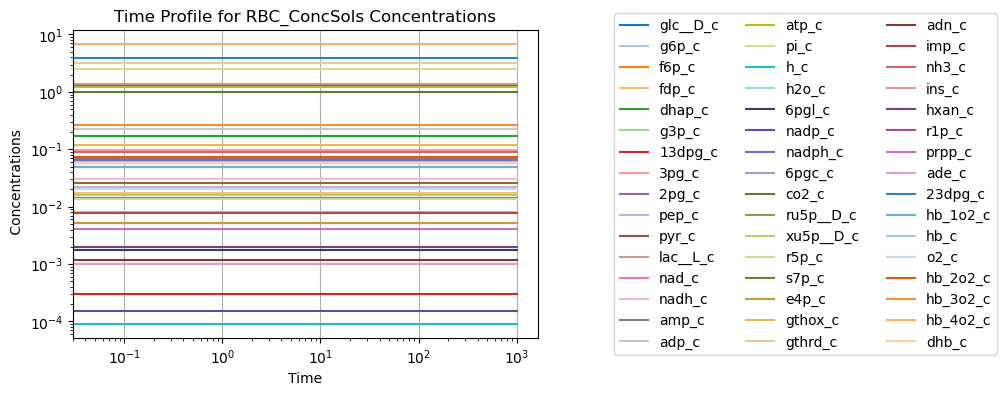

In [7]:
(t0, tf) = (0, 1e3)
sim = Simulation(RBC)
sim.find_steady_state(RBC, strategy="simulate", update_values=True)
conc_sol, flux_sol = sim.simulate(RBC, time=(t0, tf))

conc_sol.view_time_profile()

### Export Model

Export your RBC model to the `models` directory.

In [8]:
json.save_json_model(mass_model=RBC, filename= RBC.id + ".json")

In [10]:
#print(RBC.summary())            # if available in your MASSpy version
print(f"Reactions: {len(RBC.reactions)}, Metabolites: {len(RBC.metabolites)}, Compartments: {len(RBC.compartments)}")
print("Boundary reactions:", [r.id for r in RBC.boundary])


Reactions: 53, Metabolites: 48, Compartments: 1
Boundary reactions: ['SK_pyr_c', 'SK_lac__L_c', 'SK_glc__D_c', 'SK_h_c', 'SK_h2o_c', 'SK_co2_c', 'SK_adn_c', 'SK_ade_c', 'SK_ins_c', 'SK_hxan_c', 'SK_nh3_c', 'SK_pi_c', 'SK_o2_c']
